In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
# from labellines import labelLine, labelLines
from matplotlib.gridspec import GridSpec
from netCDF4 import Dataset as NetCDFFile 
import matplotlib
# from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline
import cartopy
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader
from mpl_toolkits.axes_grid1 import AxesGrid, ImageGrid
import geopandas as gpd
# import pygeos
# Import modules
import xarray as xr
import matplotlib.ticker as mticker
import datetime
from matplotlib.dates import (AutoDateLocator, YearLocator, MonthLocator,
                              DayLocator, WeekdayLocator, HourLocator,
                              MinuteLocator, SecondLocator, MicrosecondLocator,
                              RRuleLocator, rrulewrapper, MONTHLY,
                              MO, TU, WE, TH, FR, SA, SU, DateFormatter,
                              AutoDateFormatter, ConciseDateFormatter)
from pathlib import Path
import scipy.interpolate as spi
import math
# from mpmath import sec
from joblib import Parallel, delayed
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

/Users/weitao/anaconda3/lib/python3.10/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
hk = pd.read_pickle('GEOS-Chem/GEMS_N_GC_2021')
hk = hk[(hk['lat']==22.5)&(hk['lon']==114.375)]
hk = hk[(hk['Season']=='Summer')]
hk['VCD'] = hk['VCD']/1e15
hk['hour'] = hk['hour']+8
hk['ID'] = hk['month']*100+hk['hour']
hk.columns = ['lat', 'lon', 'GEMS', 'month', 'hour', 'GC_AK', 'GC', 'Season',
       'ID']
print(len(hk))
hk.head()


48


,lat,lon,GEMS,month,hour,GC_AK,GC,Season,ID
4254,22.5,114.375,8.800385,6,11,11.619439,11.532797,Summer,611
3861,22.5,114.375,10.946268,7,15,12.332173,12.615407,Summer,715
4132,22.5,114.375,10.020607,8,12,11.707256,12.206442,Summer,812
4198,22.5,114.375,8.800385,6,11,11.619439,11.532797,Summer,611
3849,22.5,114.375,9.009856,6,12,11.441066,11.737311,Summer,612


In [3]:
hk1 = hk[['GEMS','month','hour']]
hk2 = hk[['GC_AK','month','hour']]
hk3 = hk[['GC','month','hour']]
hk1.columns=['HCHO','month','hour']
hk1['Type']='GEMS'
hk2.columns=['HCHO','month','hour']
hk2['Type']='GC_AK'
hk3.columns=['HCHO','month','hour']
hk3['Type']='GC'
hkk = pd.concat([hk1,hk2,hk3])
hkk

/var/folders/4y/knznw84s4p5d2d77tb6wyq6h0000gn/T/ipykernel_23688/4073921933.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk1['Type']='GEMS'
/var/folders/4y/knznw84s4p5d2d77tb6wyq6h0000gn/T/ipykernel_23688/4073921933.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk2['Type']='GC_AK'
/var/folders/4y/knznw84s4p5d2d77tb6wyq6h0000gn/T/ipykernel_23688/4073921933.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,HCHO,month,hour,Type
4254,8.800385,6,11,GEMS
3861,10.946268,7,15,GEMS
4132,10.020607,8,12,GEMS
4198,8.800385,6,11,GEMS
3849,9.009856,6,12,GEMS
...,...,...,...,...
3924,11.845536,8,14,GC
3930,11.380275,8,15,GC
3819,11.380275,8,15,GC
3003,10.849653,8,16,GC


In [4]:
hkk.columns = ['HCHO', 'Month', 'Hour', 'Type']

In [5]:
monthD = {6:'June',7:'July',8:'August'}
hkk['Month'] = hkk['Month'].map(monthD)

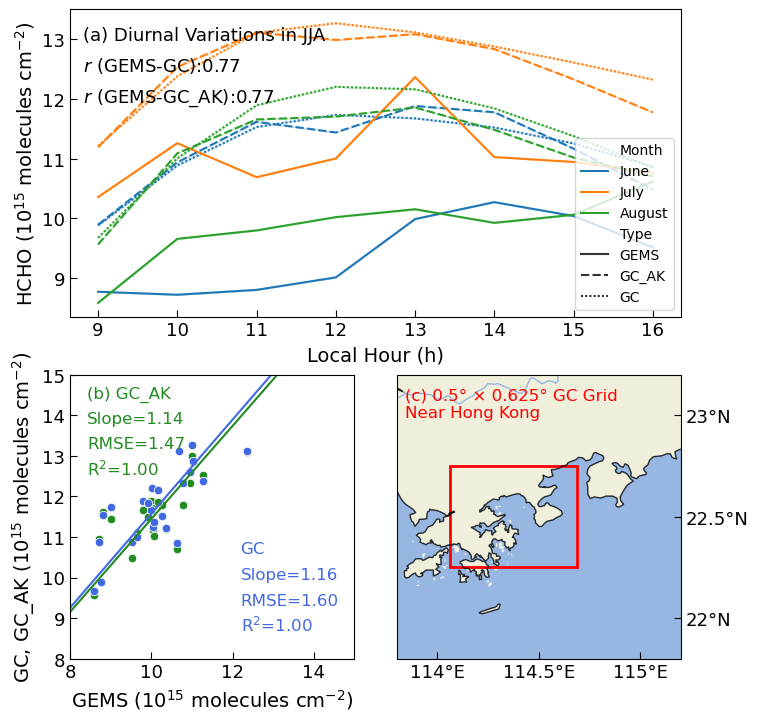

In [6]:
from scipy.stats import pearsonr
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import cartopy.io.img_tiles as cimgt
import matplotlib.patches as mpatches

# hktif = NaturalEarthFeature(category='Raster', scale='50m',
# #                             facecolor='none',
#                              name='Natural Earth 1')
cm = 1/2.54  # centimeters in inches
plt.rcParams['figure.dpi']=400
plt.style.use('default')

fig = plt.figure(figsize=(20*cm, 20*cm))
# fig = plt.figure(layout="constrained", figsize=(15*cm, 36*cm))
# fig = plt.figure(layout="constrained", figsize=(32*cm, 36*cm))
# fig.suptitle("Summertime Diurnal GEMS and GEOS-Chem HCHO near Hong Kong",size=14,weight='bold')
plt.subplots_adjust(wspace=0.15, hspace=0.15,top=0.95)

gs = GridSpec(2, 2, figure=fig,)
# formatter = matplotlib.dates.DateFormatter('%H:%M')
formatter = matplotlib.dates.DateFormatter('%#H')

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
# ax = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1], projection=cartopy.crs.PlateCarree())
ax1.tick_params(direction = 'in',size=5, labelsize=13) 
ax2.tick_params(direction = 'in',size=5, labelsize=13) 
ax3.tick_params(direction = 'in',size=5, labelsize=13) 
# ax1
sns.lineplot(data=hkk, x='Hour',y='HCHO',hue='Month',style='Type',ax=ax1)
ax1.legend(loc='lower right')
corr = pearsonr(hk['GEMS'],hk['GC'])
corr2 = pearsonr(hk['GEMS'],hk['GC_AK'])
ax1.text(0.02,0.9,'(a) Diurnal Variations in JJA'.format(corr[0]),transform=ax1.transAxes,size=13)
ax1.text(0.02,0.8,'$\it{r}$ (GEMS-GC):'+ '{:.2f}'.format(corr[0]),transform=ax1.transAxes,size=13)
ax1.text(0.02,0.7,'$\it{r}$ (GEMS-GC_AK):'+ '{:.2f}'.format(corr2[0]),transform=ax1.transAxes,size=13)
ax1.set_ylabel('HCHO (10$^{15}$ molecules cm$^{-2}$)', color="black",size=14)
ax1.set_xlabel('Local Hour (h)', color="black",size=14)


# ax2
sns.scatterplot(data=hk, x='GEMS',y='GC_AK', ax=ax2, color="forestgreen")
ax2.tick_params(axis='y', colors="black")
ax2.set_ylabel('GC, GC_AK (10$^{15}$ molecules cm$^{-2}$)', color="black",size=14)

sns.scatterplot(data=hk, x='GEMS',y='GC', ax=ax2, color="royalblue",)
# ax2.yaxis.tick_right()

ax2.axis('square')
ax2.set_xlim(8,15)
ax2.set_ylim(8,15)

resultGC = smf.ols(formula='GC ~ GEMS - 1', data = hk).fit()
x1,y1=[0,15],[0,15*float(resultGC.params['GEMS'])]
ax2.plot(x1, y1, color = 'royalblue')
ax2.text(0.6,0.28,"Slope={:.2f}".format(resultGC.params['GEMS']),transform=ax2.transAxes,size=12,color='royalblue')
ax2.text(0.6,0.1,"R$^2$={:.2f}".format(resultGC.rsquared),transform=ax2.transAxes,size=12,color='royalblue')
y_pred=resultGC.predict(hk['GEMS'])
rmsee = rmse(hk['GEMS'],y_pred)
ax2.text(0.6,0.19,"RMSE={:.2f}".format(rmsee),transform=ax2.transAxes,size=12,color='royalblue')
ax2.text(0.6,0.37,"GC",transform=ax2.transAxes,size=12,color='royalblue')

resultGC_AK = smf.ols(formula='GC_AK ~ GEMS - 1', data = hk).fit()
x1,y1=[0,15],[0,15*float(resultGC_AK.params['GEMS'])]
ax2.plot(x1, y1, color = 'forestgreen')
ax2.text(0.06,0.92,"(b) GC_AK",transform=ax2.transAxes,size=12,color='forestgreen')
ax2.text(0.06,0.83,"Slope={:.2f}".format(resultGC_AK.params['GEMS']),transform=ax2.transAxes,size=12,color='forestgreen')
ax2.text(0.06,0.65,"R$^2$={:.2f}".format(resultGC_AK.rsquared),transform=ax2.transAxes,size=12,color='forestgreen')
y_pred=resultGC_AK.predict(hk['GEMS'])
rmsee = rmse(hk['GEMS'],y_pred)
ax2.text(0.06,0.74,"RMSE={:.2f}".format(rmsee),transform=ax2.transAxes,size=12,color='forestgreen')
ax2.set_xlabel('GEMS (10$^{15}$ molecules cm$^{-2}$)', color="black",size=14)

# ax3
extent = [113.8, 115.2, 21.8, 23.2]
# extent = [113.875, 114.875, 22, 23]
ax3.set_extent(extent)
ax3.add_feature(cfeature.COASTLINE, linewidth=1, alpha=0.8)
ax3.add_feature(cartopy.feature.LAND)
ax3.add_feature(cartopy.feature.OCEAN)
# ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
# ax3.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
ax3.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax3.add_feature(cartopy.feature.RIVERS)
ax3.add_patch(mpatches.Rectangle(xy=[ 114.0625,22.25], width=0.625, height=0.5, facecolor='none', edgecolor='red',linewidth=2,alpha=1, transform=ccrs.PlateCarree()))
ax3.text(0.03,0.85,u"(c) 0.5\u00b0 \u00D7 0.625\u00b0 GC Grid \nNear Hong Kong",transform=ax3.transAxes,size=12,color='red')
ax3.set_xticks(np.arange(114,115.1,0.5), crs=ccrs.PlateCarree())
ax3.set_yticks(np.arange(22,23.1,0.5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.tick_right()
# request = cimgt.OSM()
# ax.add_image(request)

# ax3.add_feature(hktif)
# ax3.stock_img()